In [1]:
import dlib, cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.patheffects as path_effects

#얼굴 탐지 모델
detector=dlib.get_frontal_face_detector()
#얼굴 랜드마크 탐지 모델
sp=dlib.shape_predictor('models/shape_predictor_68_face_landmarks.dat')
#얼굴 인식 모델
facerec=dlib.face_recognition_model_v1('models/dlib_face_recognition_resnet_model_v1.dat')


RuntimeError: Unable to open models/shape_predictor_68_face_landmarks.dat

In [7]:
#얼굴 찾기, 얼굴 랜드마크 찾기(눈, 코, 입 같은거)
def find_faces(image):
    dets=detector(image, 1)   #얼굴 찾은 결과물이 들어감

    #얼굴 하나도 못 찾았을 경우 빈 배열 반환
    if len(dets)==0:
        return np.empty(0), np.empty(0), np.empty(0)

    rects, shapes=[], []
    shapes_np=np.zeros((len(dets), 68, 2), dtype=np.int)
    #얼굴의 갯수만큼 루프를 돔
    for k, d in enumerate(dets):
        rect=((d.left(), d.top()), (d.right(), d.bottom()))
        rects.append(rect)

        #68개의 점이 나옴. 랜드마크 찾기
        shape=sp(image, d)  

        for i in range(0, 68):
            shapes_np[k][i]=(shape.part(i).x, shape.part(i).y)  

        shapes.append(shape)  

    return rects, shapes, shapes_np

#랜드마크 정보를 인코더에 넣어주면 128개의 벡터가 나옴. 이 벡터들의 거리로 같은 사람인지 다른사람인지 판단
def encode_faces(image, shapes):
    face_decriptors=[]  #결과값 저장 리스트

    #랜드마크들의 배열 집합 크기만큼 루프
    for shape in shapes:
        #얼굴을 인코딩. 이 함수에는 전체 이미지와 랜드마크가 들어감
        face_descriptor=facerec.compute_face_descriptor(image, shape) 
        face_decriptors.append(np.array(face_descriptor))

    return np.array(face_decriptors)

In [8]:
#Compute Saved Face Descriptions
img_paths={
    'neo': 'image/neo.jpg',
    'trinity': 'image/trinity.jpg',
    'morpheus': 'image/morpheus.jpg',
    'smith': 'image/smith.jpg'
}

descs={
    'neo': None,
    'trinity': None,
    'morpheus': None,
    'smith': None
}

for name, img_path in img_paths.items():
    img_bgr=cv2.imread(img_path)
    #컬러 체계를 바꿈
    img_rgb=cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    #인코딩하는 함수에 전체 이미지와 각 사람의 랜드마크를 넣어줌
    #인코딩된 결과를 각 사람의 이름에 맞게 저장
    _, img_shapes, _=find_faces(img_rgb)
    descs[name]=encode_faces(img_rgb, img_shapes)[0]

np.save('image/descs.npy', descs)
#print(descs)

error: OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


In [9]:
#Compute Input
#단체 사진에서 얼굴을 찾음
img_bgr=cv2.imread('image/matrix.jpg')
img_rgb=cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

rects, shapes, _=find_faces(img_rgb)
descriptors=encode_faces(img_rgb, shapes)
     

error: OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


NameError: name 'img_rgb' is not defined

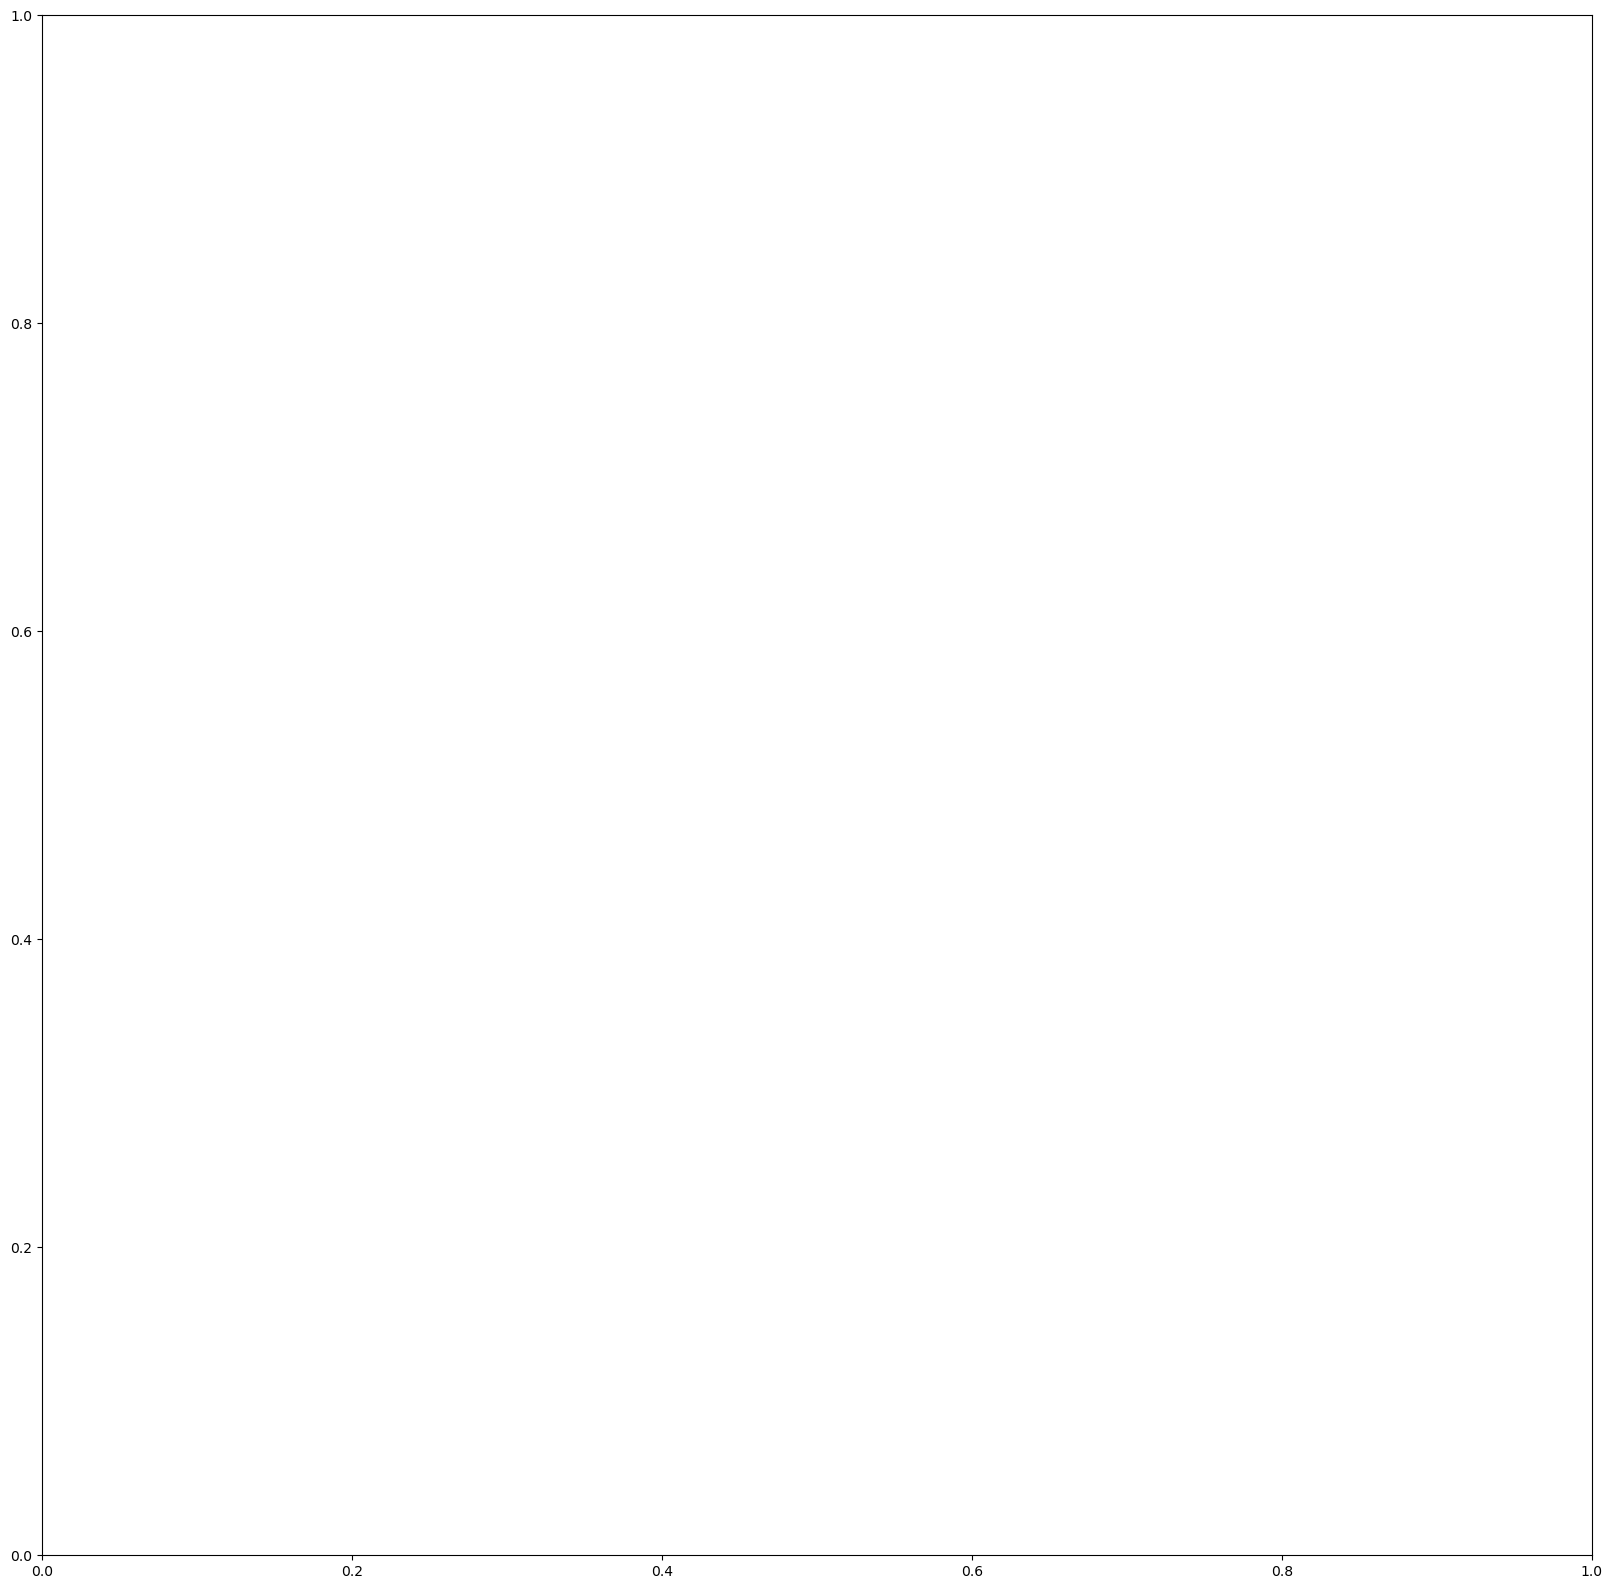

In [10]:
#Visualize Output
#각 얼굴 사진에서 얻은 정보와 전체 인물들이 나온 사진에서의 얼굴 비교
fig, ax=plt.subplots(1, figsize=(20, 20))
ax.imshow(img_rgb)

for i, desc in enumerate(descriptors):
    found=False
    for name, saved_desc in descs.items():
        #두 벡터 사이의 유클리드 거리를 구함
        dist=np.linalg.norm([desc]-saved_desc, axis=1)

        if dist<0.6:
            found=True
            #이름 쓰는 부분
            text=ax.text(rects[i][0][0], rects[i][0][1], name, color='b', fontsize=40, fontweight='bold')
            text.set_path_effects([path_effects.Stroke(linewidth=10, foreground='white'), path_effects.Normal()])

            #사각형 그리는 부분
            rect=patches.Rectangle(rects[i][0], rects[i][1][1]-rects[i][0][1], rects[i][1][0]-rects[i][0][0], linewidth=2, edgecolor='w', facecolor='none')
            ax.add_patch(rect)
            break

        if not found:
            text=ax.text(rects[i][0][0], rects[i][0][1], 'unknown', color='r', fontsize=20, fontweight='bold')
            rect=patches.Rectangle(rects[i][0], rects[i][1][1]-rects[i][0][1], rects[i][1][0]-rects[i][0][0], linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            
plt.axis('off')
plt.savefig('result/output.png')
plt.show()